# DCGAN on Cifar10 dataset
This notebook creates a DCGAN and trained the GAN with one class of image in the Cifar10 Dataset.

In [33]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.keras import layers
import time

from IPython import display

In [34]:
from tensorflow.keras.datasets import cifar10

In [35]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [36]:
#(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
(train_images, train_labels), (x_test, y_test) = cifar10.load_data()

In [37]:
truck_label = np.where(train_labels==9)
truck_img = train_images[truck_label[0]]

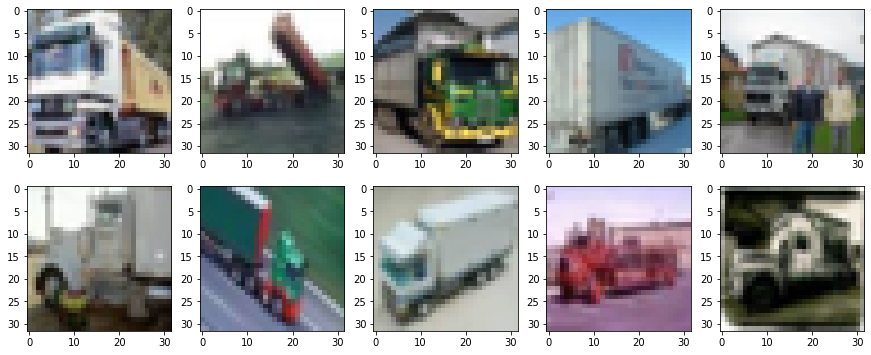

In [38]:
fig, axs = plt.subplots(2,5, figsize=(15, 6))
pic = 0
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i,j].imshow(truck_img[pic])
        #axs[i,j].set_title(labels[y_train[pic][0]])
        pic+=1

In [39]:
truck_img = truck_img.reshape(truck_img.shape[0], 32, 32, 3).astype('float32')
truck_img = (truck_img -  127.5) / 127.5  # Normalize the images to [-1, 1]

In [40]:
BUFFER_SIZE = 60000
BATCH_SIZE = 128

In [41]:
train_dataset = tf.data.Dataset.from_tensor_slices(truck_img).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Generate the Models

In [65]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)

    return model

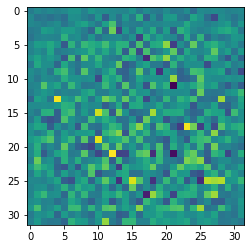

In [66]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [67]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(128))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1))

    return model

In [68]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00089191]], shape=(1, 1), dtype=float32)


In [69]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [70]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [71]:
generator_optimizer = tf.keras.optimizers.Adam(3e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(3e-4)

In [72]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [73]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [74]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [75]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [76]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  img = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(img.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow((np.array(img[i, :, :, :])*127.5+127.5).astype(np.int32))
      plt.axis('off')

  plt.savefig('images/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

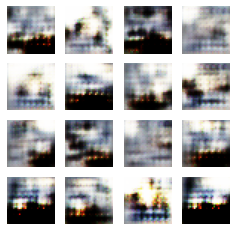

In [77]:
train(train_dataset, EPOCHS)

In [78]:
noise = tf.random.normal([16, noise_dim])
img = generator(noise, training= False)

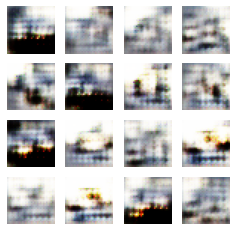

In [79]:
fig = plt.figure(figsize=(4, 4))

for i in range(img.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow((np.array(img[i, :, :, :])*127.5+127.5).astype(np.int32))
    plt.axis('off')

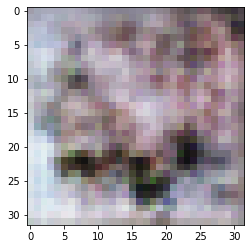

In [64]:
plt.imshow((np.array(img[6, :, :, :])*127.5+127.5).astype(np.int32))

In [30]:
pic = np.array(img[3])

In [31]:
pic = pic*127.5+127.5

In [32]:
pic = pic.astype(np.int32)